# import the most used libraries

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# read image that has samples of terran, road and obstacls

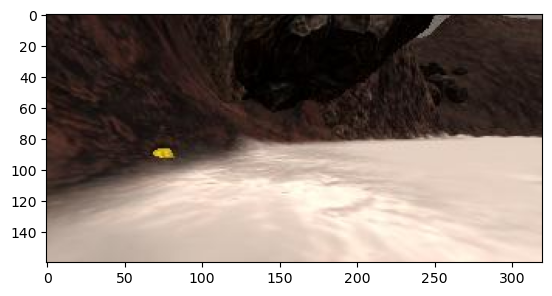

In [42]:
img1=cv2.imread("/home/loay/Downloads/IMG/robocam_2017_05_02_11_16_27_691.jpg")
plt.imshow(img1[:,:,::-1])

# define source, dst and dst_size

In [43]:
src=np.float32([[10,140],[300,140],[210,95],[120,95]])
size=3
offset=10
dst=np.float32([[img.shape[1]/2-size,img.shape[0]-offset]
              ,[img.shape[1]/2+size,img.shape[0]-offset],
             [img.shape[1] /2+ size, img.shape[0] - 2*size - offset],
            [img.shape[1] /2- size, img.shape[0] - 2*size - offset]])

# get the birdeye_view for the two images using perspect_transform function

In [44]:
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped

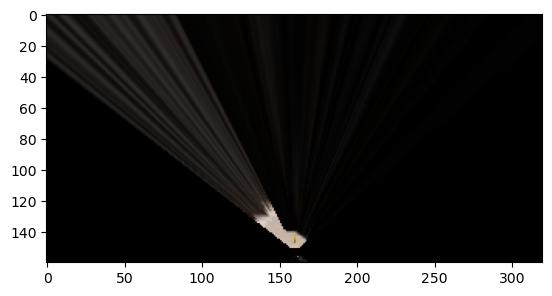

In [45]:
img_transformed = perspect_transform(img1, src, dst)
plt.imshow(img_transformed1[:,:,::-1])

# get the thresholed image for the terran from image_2 and the obstical

In [46]:
def color_thresh_road(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select


def color_thresh_obsticals(img, rgb_thresh=(160, 160, 160)):

    color_select = np.zeros_like(img[:,:,0])
    below_thresh = (img[:,:,0] < rgb_thresh[0]) \
                & (img[:,:,1] < rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2]) \
                &(img[:,:,0] != 0) \
                &(img[:,:,1] != 0) \
                &(img[:,:,2] != 0)                
    color_select[below_thresh] = 1
    return color_select


def color_thresh_rock(img):
    
    img1=img[:,:,::-1]
    hsv = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)

    #Define range of yellow colors in HSV
    lower_yellow = np.array([10, 100, 100],dtype='uint8')
    upper_yellow = np.array([255, 225 ,255],dtype='uint8')
    
    #Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    #mask=cv2.bitwise_and(img,img,mask=out)
    return mask

In [47]:
img_terrain = color_thresh_road(img_transformed,rgb_thresh=(160, 160, 160))
    
img_rock = color_thresh_rock(img_transformed)
                    
img_obs = color_thresh_obsticals(img_transformed,rgb_thresh=(160, 160, 160))

Text(0.5, 1.0, 'obstical threshold')

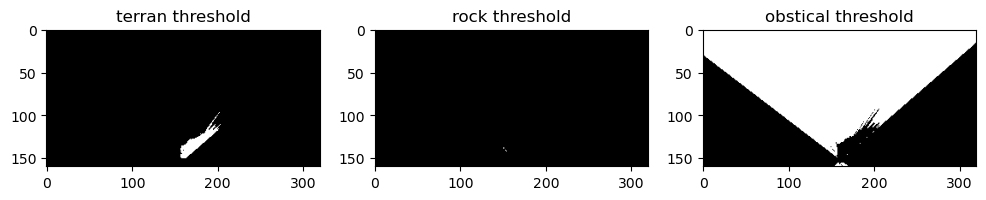

In [48]:
figur=plt.figure(figsize=(12,9))
plt.subplot(131)
plt.imshow(img_terrain,cmap='gray')
plt.title("terran threshold")
plt.subplot(132)
plt.imshow(img_rock, cmap='gray')
plt.title("rock threshold")
plt.subplot(133)
plt.imshow(img_obs ,cmap='gray')
plt.title("obstical threshold")

# Update Rover.vision_image (this will be displayed on left side of screen)

# get the the rover coords by using color_thresh_road method and plot them

In [49]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float32)
    return x_pixel, y_pixel

In [50]:
x_pix_road,y_pix_road=rover_coords(img_terrain)
    
x_pix_rock,y_pix_rock=rover_coords(img_rock)
    
x_pix_obs,y_pix_obs=rover_coords(img_obs)

Text(0.5, 1.0, 'obstacl rover coords')

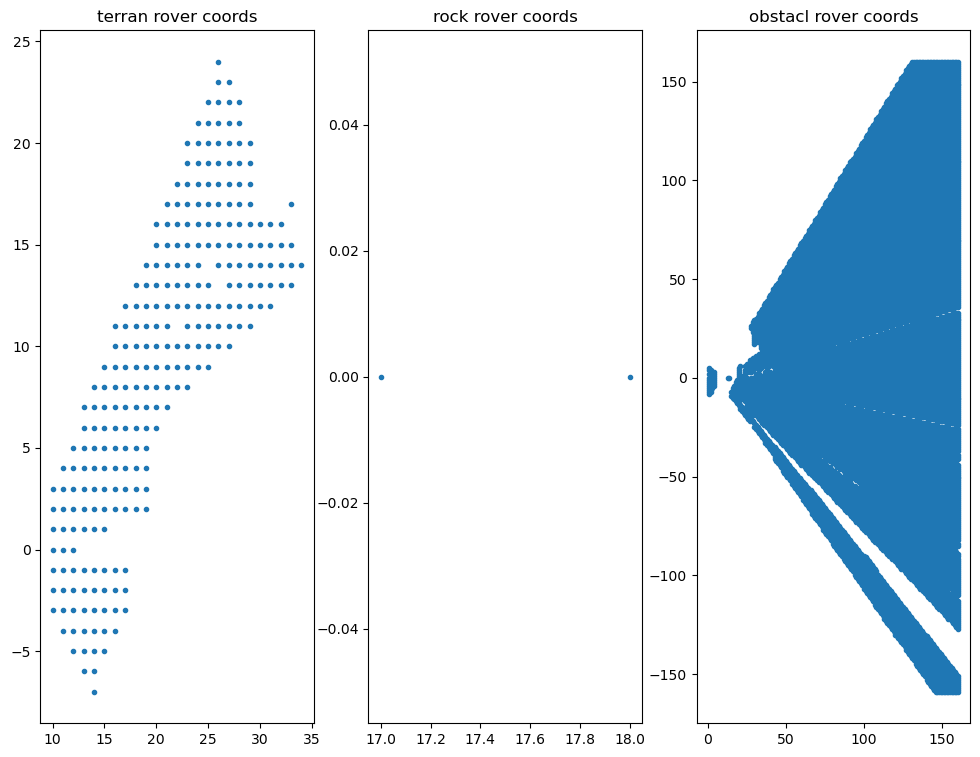

In [37]:
figur=plt.figure(figsize=(12,9))
plt.subplot(131)
plt.plot(x_pix_road,y_pix_road,'.')
plt.title("terran rover coords")
plt.subplot(132)
plt.plot(x_pix_rock,y_pix_rock,'.')
plt.title("rock rover coords")
plt.subplot(133)
plt.plot(x_pix_obs,y_pix_obs,'.')
plt.title("obstacl rover coords")

# Convert rover-centric pixel values to world coordinates

In [51]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float32)
    return x_pixel, y_pixel

def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    
    xpix_translated = ((xpix_rot / scale) + xpos)
    ypix_translated = ((ypix_rot / scale) + ypos)
    # Return the result  
    return xpix_translated, ypix_translated



def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    return x_pix_world, y_pix_world


In [54]:
#get parameters from csv file

X_pos=103.5464
Y_pos=94.43549
Yaw=77.56207
scale=36
x_pix_world_road ,y_pix_world_road=pix_to_world(x_pix_road, y_pix_road, X_pos, Y_pos, Yaw, 200, scale)
    
x_pix_world_rock,y_pix_world_rock=pix_to_world(x_pix_rock,y_pix_rock, X_pos, Y_pos, Yaw, 200, scale)
    
x_pix_world_obs,y_pix_world_obs=pix_to_world(x_pix_obs, y_pix_obs, X_pos, Y_pos, Yaw, 200, scale)

# Update Rover worldmap (to be displayed on right side of screen)


In [59]:
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# convert rover-centric pixel positions to polar coordinates


In [63]:
dist, angle=to_polar_coords(x_pix_road,y_pix_road)

In [64]:
dist1=np.mean(dist)
angle1=np.mean(angle)

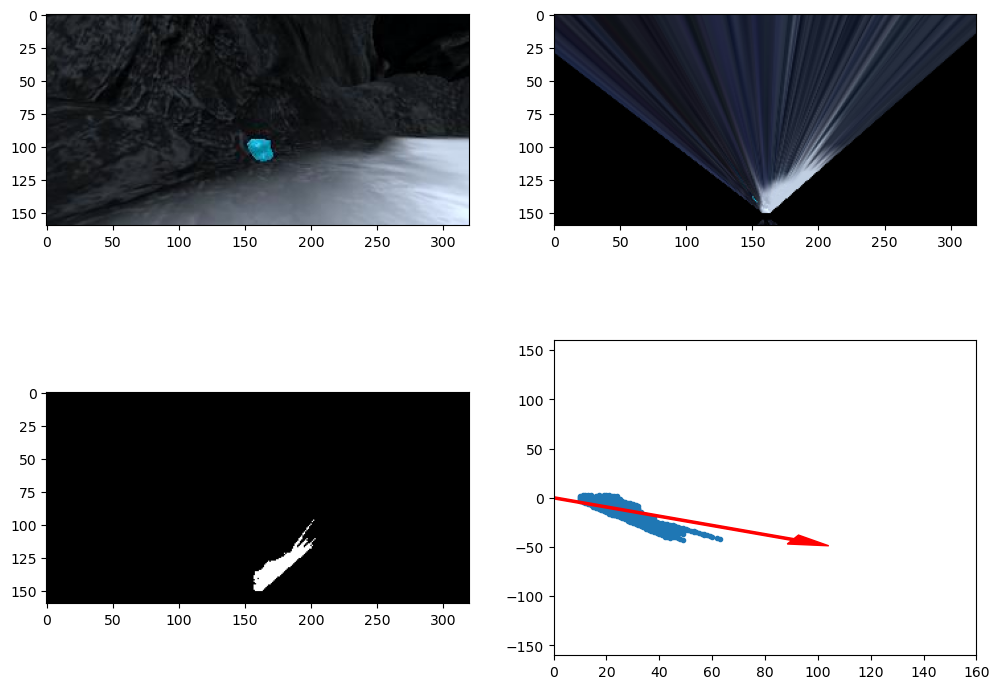

In [67]:
figure=plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
plt.imshow(img_transformed)
plt.subplot(223)
plt.imshow(img_terrain,cmap='gray')
plt.subplot(224)
plt.plot(x_pix_road,y_pix_road,'.')
plt.ylim(-160,160)
plt.xlim(0,160)
arraw=100
X_arraw=arraw*np.cos(angle1)
Y_arraw=arraw*np.sin(angle1)
plt.arrow(0,0,X_arraw,Y_arraw,color='red',zorder=2,head_width=10,width=2)